# **Convective State Analysis**

The goal is to analyze each convective state independently, thresholding based on the MLD in the Weddell Sea.

In [3]:
import os
import warnings
warnings.filterwarnings("ignore", message="invalid value encountered in true_divide")
warnings.filterwarnings("ignore", message="Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range")
warnings.filterwarnings("ignore", message="invalid value encountered in reduce")
warnings.filterwarnings("ignore", message="Degrees of freedom <= 0 for slice.")

import xarray as xr
import numpy as np
import math
import pickle as pkl

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib as mpl

from cartopy import crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point

%load_ext autoreload
%autoreload 2
import hmei.processing as pcs
import hmei.visualization as vis

# MLD Timeseries
Inspect annual and monthly mean MLD timeseries to develop a method for defining the convective states.

In [4]:
rootdir = '/home/bbuchovecky/storage/so_predict_derived/CTRL/'
var = 'mld'

pcs.dir_inspect('/home/bbuchovecky/storage/so_predict_derived/MLD_ENSEMBLE')

['mld_ens_global_annual_mean.nc',
 'mld_ens_global_monthly_anom.nc',
 'mld_ens_global_monthly_mean.nc',
 'mld_ens_so_annual_mean.nc',
 'mld_ens_so_monthly_anom.nc',
 'mld_ens_so_monthly_mean.nc']

In [3]:
def open_ctrl(var, timescale, metric, reg='so', form='ts', print_path=True):
    rootdir = '/home/bbuchovecky/storage/so_predict_derived/CTRL/'
    subdir = var.upper()+'/'
    filename = var.lower()+'_'+form+'_'+reg+'_'+timescale+'_'+metric+'.nc'
    
    if print_path:
        print('opened - '+rootdir+subdir+filename)
    return xr.open_dataset(rootdir+subdir+filename)
    
def open_ens(var, reg, timescale, metric, form='ts', print_path=True):
    rootdir = '/home/bbuchovecky/storage/so_predict_derived/'
    subdir = var.upper()+'_ENSEMBLE/'
    filename = var.lower()+'_ens_'+reg+'_'+timescale+'_'+metric+'.nc'
    
    if print_path:
        print('opened - '+rootdir+subdir+filename)
    return xr.open_dataset(rootdir+subdir+filename)

mld_ts_annual_mean = open_ctrl('mld', 'annual', 'mean')
mld_ts_monthly_mean = open_ctrl('mld', 'monthly', 'mean')

opened - /home/bbuchovecky/storage/so_predict_derived/CTRL/MLD/mld_ts_so_annual_mean.nc
opened - /home/bbuchovecky/storage/so_predict_derived/CTRL/MLD/mld_ts_so_monthly_mean.nc


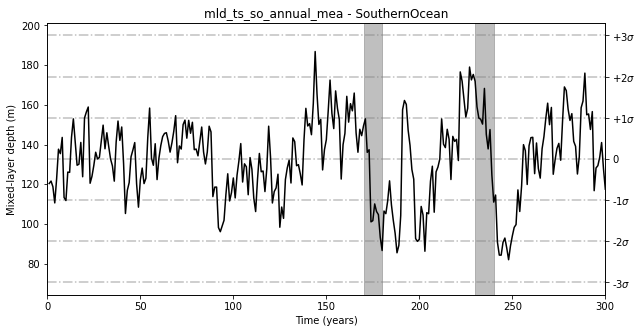

In [4]:
fig,ax = vis.stdev_plot(mld_ts_annual_mean, 'SouthernOcean')

ax.axvspan(170,180, color='gray', alpha=0.5)
ax.axvspan(230,240, color='gray', alpha=0.5)

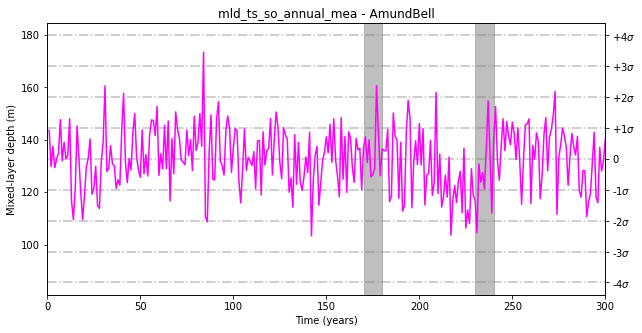

In [5]:
fig,ax = vis.stdev_plot(mld_ts_annual_mean, 'AmundBell')

# ax.axvspan(169,179,color='gray', alpha=0.5)
ax.axvspan(170,180,color='gray', alpha=0.5)
ax.axvspan(230,240, color='gray', alpha=0.5)

In [10]:
def open_ctrl(
    var, timescale, metric, reg='so', form='ts', print_path=True):
    
    rootdir = '/home/bbuchovecky/storage/so_predict_derived/CTRL/'
    subdir = var.upper()+'/'
    filename = var.lower()+'_'+form+'_'+reg+'_'+timescale+'_'+metric+'.nc'
    
    if print_path:
        print('opened - '+rootdir+subdir+filename)
    return xr.open_dataset(rootdir+subdir+filename)


def ctrl_grid_plot(
    var, ts=None, timescale='annual', metric='mean', sharey=True, ens_ticks=True, ens_spans=True, figsize=(12,6), bbox_to_anchor=(1,1.01)):
    
    if metric =='anom':
        assert timescale == 'monthly', '\'anom\' requires monthly timescale'
    
    if ts == None:
        ts = open_ctrl(var, timescale, metric, reg='so', form='ts', print_path=True)
    assert len(ts.data_vars) == 6, '\'annual_mean\' needs 6 data variables corresponding to each region in the Southern Ocean.'
    
    ## import dictionaries containing variable and region details
    file = open('/home/bbuchovecky/storage/so_predict_derived/plotting_dicts.pkl','rb')
    plotting_dicts = pkl.load(file)
    file.close()
    
    reg_colors = plotting_dicts['reg_colors']
    var_colors = plotting_dicts['var_colors']
    reg_names = plotting_dicts['reg_names']
    var_su_names = plotting_dicts['var_su_names']
    var_lu_names = plotting_dicts['var_lu_names']
    var_ll_names = plotting_dicts['var_ll_names']
    ltx_units = plotting_dicts['ltx_units']
    uni_units = plotting_dicts['uni_units']
    ltx_var_units = plotting_dicts['ltx_var_units']
    uni_var_units = plotting_dicts['uni_var_units']
    
    ens_runs = np.array([22,64,106,170,232,295])
    ens_runs_labels = np.array([22,64,106,170,232,295])
    duration = 10
    
    rows = 2
    cols = 3
    
    if sharey:
        fig,axes = plt.subplots(rows,cols, sharey=True, figsize=figsize)
    if not sharey:
        fig,axes = plt.subplots(rows,cols, figsize=figsize)
        
    if timescale == 'annual':
        time = np.arange(1, ts['year'].max().values+1)
        xlim = [1, ts['year'].max().values]
    if timescale == 'monthly':
        try:
            time = np.arange(1, ts['time'].size+1)
            xlim = [1, ts['time'].size]
        except:
            time = np.arange(1, ts['month'].size+1)
            xlim = [1, ts['month'].size]
        ens_runs = ens_runs*12
        duration = duration*12

    ## plot all regions
    for (reg, i) in zip(ts.data_vars, range(6)):
        axes[int(i/3),i%3].plot(time, ts[reg], color=reg_colors[reg])
        axes[int(i/3),i%3].set(xlabel='Time (yr)', xlim=xlim)
        axes[int(i/3),i%3].set_title(reg_names[reg])
        
        if ens_ticks:
            axes[int(i/3),i%3].set_xticks(ens_runs)
            axes[int(i/3),i%3].set_xticklabels(ens_runs_labels)
            
        if not ens_ticks and timescale == 'monthly':
            axes[int(i/3),i%3].set_xticks(np.arange(0,301*12,50*12))
            axes[int(i/3),i%3].set_xticklabels(np.arange(0,301,50))
            
        if ens_spans:
            for t in ens_runs:
                if t == 22 or t == 22*12:
                    axes[int(i/3),i%3].axvspan(t, t+duration, alpha=0.25, color='gray', label='Ensemble Runs')
                else:
                    axes[int(i/3),i%3].axvspan(t, t+duration, alpha=0.25, color='gray')
        
        if sharey and i%3 == 0:
            axes[int(i/3),i%3].set_ylabel(var_su_names[var]+' ('+ltx_units[var]+')')
            
        if not sharey:
            axes[int(i/3),i%3].set_ylabel(var_su_names[var]+' ('+ltx_units[var]+')')
            
    if ens_spans:
#         axes[0,2].legend(bbox_to_anchor=bbox_to_anchor)
        axes[0,2].legend(loc='upper right')
            
    fig.suptitle(var_lu_names[var]+' - '+timescale.capitalize()+' '+metric.capitalize(), fontsize=16)
    fig.tight_layout()
    
    return fig,axes

In [11]:
############################

In [54]:
def plot_stdev(
    var, reg, ts=None, timescale='annual', metric='mean', ens_ticks=True, ens_spans=True, figsize=(12,6)):
    
    if metric =='anom':
        assert timescale == 'monthly', '\'anom\' requires monthly timescale'
        
    if reg.lower() == 'global':
        ts = open_ctrl(var, timescale, metric, reg='global', form='ts', print_path=True)
        reg = 'Global'
    
    if ts == None and reg.lower() != 'global':
        ts = open_ctrl(var, timescale, metric, reg='so', form='ts', print_path=True)
    
    ## import dictionaries containing variable and region details
    file = open('/home/bbuchovecky/storage/so_predict_derived/plotting_dicts.pkl','rb')
    plotting_dicts = pkl.load(file)
    file.close()
    
    reg_colors = plotting_dicts['reg_colors']
    var_colors = plotting_dicts['var_colors']
    reg_names = plotting_dicts['reg_names']
    var_su_names = plotting_dicts['var_su_names']
    var_lu_names = plotting_dicts['var_lu_names']
    var_ll_names = plotting_dicts['var_ll_names']
    ltx_units = plotting_dicts['ltx_units']
    uni_units = plotting_dicts['uni_units']
    ltx_var_units = plotting_dicts['ltx_var_units']
    uni_var_units = plotting_dicts['uni_var_units']
    
    ens_runs = np.array([22,64,106,170,232,295])
    ens_runs_labels = np.array([22,64,106,170,232,295])
    duration = 10
          
    if timescale == 'annual':
        time = np.arange(1, ts['year'].max().values+1)
        xlim = [1, ts['year'].max().values]
        
    if timescale == 'monthly':
        try:
            time = np.arange(1, ts['time'].size+1)
            xlim = [1, ts['time'].size]
        except:
            time = np.arange(1, ts['month'].size+1)
            xlim = [1, ts['month'].size]
        ens_runs = ens_runs*12
        duration = duration*12
    
    mean = ts[reg].mean()
    stdev = ts[reg].std()

    fig,ax = plt.subplots(figsize=figsize)
    
    ax.plot(time, ts[reg], color=reg_colors[reg])
    ax.set(xlim=xlim)
    
    if ens_ticks:
        ax.set_xticks(ens_runs)
        ax.set_xticklabels(ens_runs_labels)
    
    if not ens_ticks and timescale == 'monthly':
        ax.set_xticks(np.arange(0,301*12,50*12))
        ax.set_xticklabels(np.arange(0,301,50))
            
    if ens_spans:
        for t in ens_runs:
            if t == 22 or t == 22*12:
                ax.axvspan(t, t+duration, alpha=0.25, color='gray', label='Ensemble Runs')
            else:
                ax.axvspan(t, t+duration, alpha=0.25, color='gray')
                
        ax.legend(loc='upper right')
        
    ax.set_title(reg_names[reg]+' - '+var_lu_names[var]+' - '+timescale.capitalize()+' '+metric.capitalize())
    ax.set_ylabel(var_su_names[var]+' ('+ltx_units[var]+')')
    ax.set_xlabel('Time (yr)')

    ## plot horizontal standard deviation lines on right y-axis
    max_sigma = 0
    while (max_sigma*stdev) <= abs(ts[reg]-mean).max():
        max_sigma += 1
    
    stdev_lines = []
    sigma_labels = []
    sigma_num = np.arange(0,max_sigma+1)
    
    if max_sigma >= 6:
        sigma_num = np.arange(0,max_sigma+1,2)
        
    for s in sigma_num:
        if s == 0:
            stdev_lines.append(mean)
            sigma_labels.append('0')
        else:
            stdev_lines.append(mean + (s*stdev))
            stdev_lines.append(mean - (s*stdev))
            sigma_labels.insert(0,'-'+str(s)+'$\sigma$')
            sigma_labels.append('+'+str(s)+'$\sigma$')
    
    ax.hlines(stdev_lines, xlim[0], xlim[1], color='gray', ls='-.', alpha=0.5)
    
    ax2 = ax.twinx()
    ax2.set(ylim=ax.get_ylim());
    ax2.set_yticks(sorted(stdev_lines));
    ax2.set_yticklabels(sigma_labels);
        
    return fig,ax

opened - /home/bbuchovecky/storage/so_predict_derived/CTRL/MLD/mld_ts_so_monthly_anom.nc


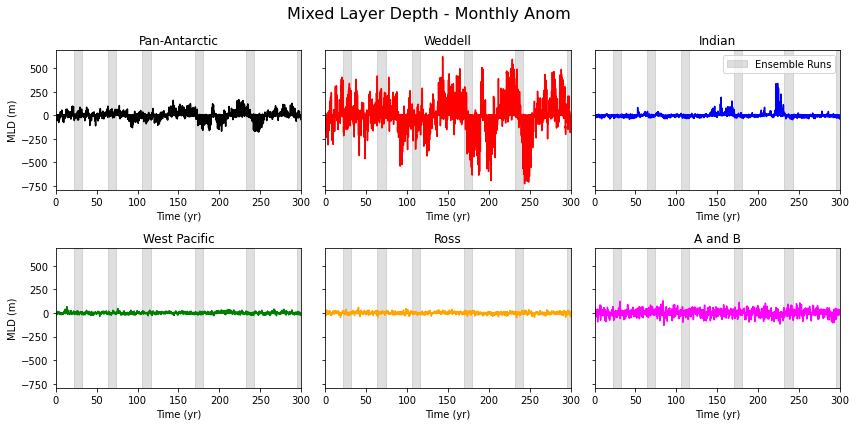

In [41]:
# mpl.rcParams['figure.dpi']= 300
%matplotlib inline

fig,axes = ctrl_grid_plot('mld', timescale='monthly', metric='anom', ens_ticks=False)

opened - /home/bbuchovecky/storage/so_predict_derived/CTRL/MLD/mld_ts_so_annual_mean.nc


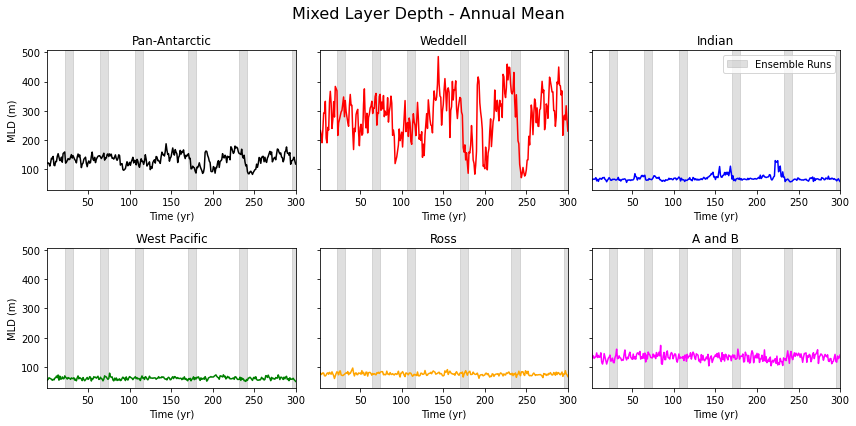

In [16]:
fig,axes = ctrl_grid_plot('mld', timescale='annual', metric='mean', ens_ticks=False)

opened - /home/bbuchovecky/storage/so_predict_derived/CTRL/MLD/mld_ts_so_monthly_anom.nc


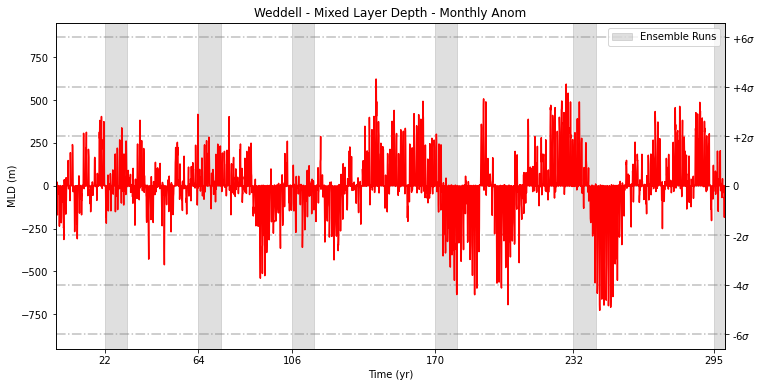

In [55]:
plot_stdev('mld', 'Weddell', timescale='monthly', metric='anom');

opened - /home/bbuchovecky/storage/so_predict_derived/CTRL/MLD/mld_ts_so_monthly_anom.nc


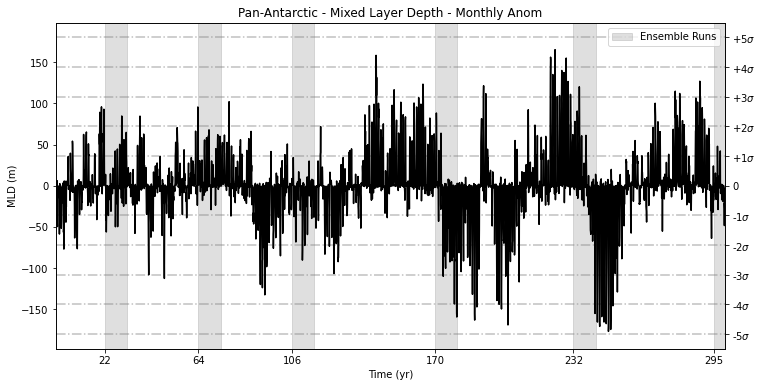

In [56]:
plot_stdev('mld', 'SouthernOcean', timescale='monthly', metric='anom');

opened - /home/bbuchovecky/storage/so_predict_derived/CTRL/MLD/mld_ts_so_annual_mean.nc


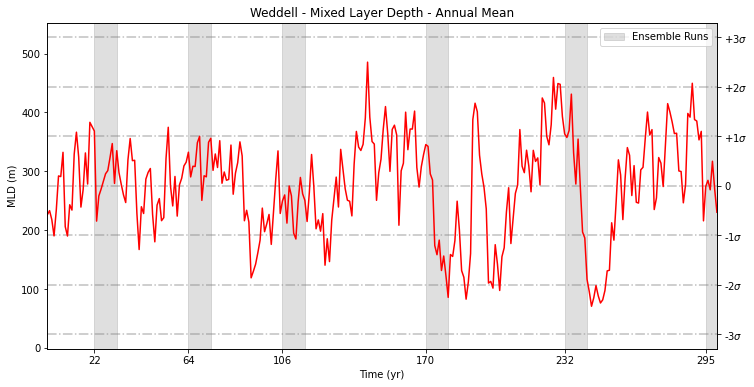

In [57]:
plot_stdev('mld', 'Weddell', timescale='annual', metric='mean');

opened - /home/bbuchovecky/storage/so_predict_derived/CTRL/MLD/mld_ts_so_annual_mean.nc


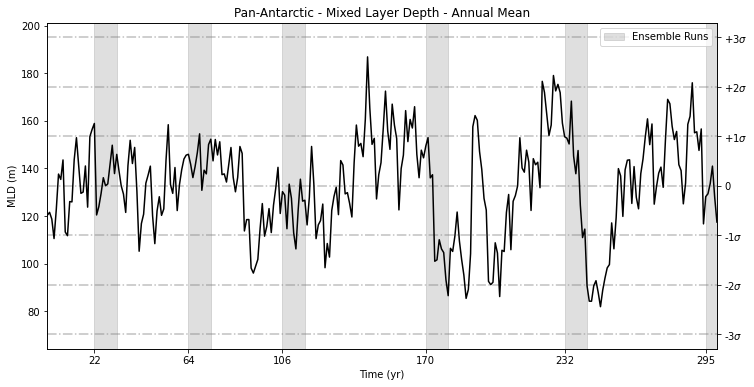

In [58]:
plot_stdev('mld', 'SouthernOcean', timescale='annual', metric='mean');

# Remove ENS01 and ENS05

Compute PPP without the ensembles that started during deep ocean convection changes. This excludes ENS01 which started in the year 170 and ENS05 which started in the year 232. However, the PPP values will not follow the same statistical significance threshold of 0.183. The goal of this computation is to gain a qualitative sense of the impact of the deep ocean convection changes.

In [49]:
def comp_subset_ppp(var, reg, timescale='monthly', save=False):

    ## import necessary data
    writedir = '/home/bbuchovecky/storage/so_predict_derived/'
    
    ## variance of the control simulation for each month
    ## dimensions (month: 12)
    subdir = 'CTRL/'+var.upper()+'/'
    filename = var.lower()+'_ts_'+reg+'_'+timescale+'_var.nc'
    ctrl_var = xr.open_dataset(writedir+subdir+filename)
    
    ## ensemble anomalies
    ## dimensions (nStart: 6, nEns: 40, nT: 120)
    subdir = var.upper()+'_ENSEMBLE/'
    filename = var.lower()+'_ens_'+reg+'_'+timescale+'_anom.nc'
    ens_anom = xr.open_dataset(writedir+subdir+filename)
    
    regions = ctrl_var.data_vars
    ens_runs = [1,2,3,5]

    ## constants
    N = 4
    M = 40

    ## numerator coefficient
    num_coeff = 1 / (N * (M - 1))

    ## numerator outer sum - across all ensembles
    num_outer_sum = np.zeros((6,120))

    PPP = np.zeros( (len(regions), 120) )

    for (iReg,r) in zip(range(len(regions)), regions):

        for j in ens_runs:          
            ## numerator inner sum - across all ensemble members
            num_inner_sum = np.zeros((40,120))

            ## ensemble mean
            ens_mean = ens_anom[r][j].mean(dim='nEns')

            for i in range(M):
                num_inner_sum[i] = np.square(ens_anom[r][j,i] - ens_mean)

            num_outer_sum[j] = np.sum(num_inner_sum, axis=0)

        ## numerator total sum
        num_sum = np.sum(num_outer_sum, axis=0)

        ## compute PPP
        for m in range(120):
            PPP[iReg][m] = 1 - ( (num_coeff * num_sum[m]) / ctrl_var[r][m%12] )
            
    ## organize PPP data in a Dataset
    PPP_da = []
    for (iReg,r) in zip(range(len(regions)), regions):
        
        PPP_reg = xr.DataArray(
                    data=PPP[iReg],
                    dims=['nT'],
                    coords=dict(
                        nT=np.arange(1,121)
                    ),
                    name=r
                )
        
        PPP_da.append(PPP_reg.copy(deep=True))
    
    PPP_ds = xr.merge(PPP_da)
    PPP_ds.attrs['name'] = var.lower()+'_ts_'+reg+'_'+timescale+'_subset_ppp.nc'
    PPP_ds.attrs['description'] = 'PPP computed only from ENS02, ENS03, ENS04, ENS06 to remove influence of deep ocean convective changes'
        
    subdir = 'PPP/'+var.upper()+'/'
    filename = var.lower()+'_ts_'+reg+'_'+timescale+'_subset_ppp.nc'    
    
    if save:
        PPP_ds.to_netcdf(writedir+subdir+filename)
        print('saved - '+writedir+subdir+filename)

    elif not save:
        print('not saved - '+writedir+subdir+filename)
        return PPP_ds

In [80]:
mld_subset_ppp = comp_subset_ppp('mld', 'so', save=True)

saved - /home/bbuchovecky/storage/so_predict_derived/PPP/MLD/mld_ts_so_monthly_subset_ppp.nc


In [63]:
mld_subset_ppp

<xarray.Dataset>
Dimensions:        (nT: 120)
Coordinates:
  * nT             (nT) int64 1 2 3 4 5 6 7 8 ... 114 115 116 117 118 119 120
Data variables:
    SouthernOcean  (nT) float64 0.9777 0.7385 0.7131 ... 0.3731 0.06482 0.03993
    Weddell        (nT) float64 0.9099 0.3685 0.2298 ... 0.3694 0.2334 0.1728
    Indian         (nT) float64 0.9338 0.5811 0.5295 ... 0.3471 0.1998 0.1703
    WestPacific    (nT) float64 0.9759 0.691 0.5667 ... 0.07406 0.04671 0.182
    Ross           (nT) float64 0.961 0.5169 0.5657 ... 0.1222 0.04417 0.05306
    AmundBell      (nT) float64 0.9225 0.4407 0.295 ... 0.1974 0.1835 -0.3216
Attributes:
    name:         mld_ts_so_monthly_subset_ppp.nc
    description:  PPP computed only from ENS02, ENS03, ENS04, ENS06 to remove...

In [65]:
def format_ppp_axes(
    ax, timescale='monthly', summer_span=True, threshold=0.183, ymin=-0.2, ppp=None):
    
    if timescale == 'monthly':
        ax.hlines(threshold, 0, 121, color='k', linestyle='-.', label='Predictability threshold ('+str(threshold)+')')
        ax.set_xlim(1,120)
        
    if timescale == 'annual':
        ax.hlines(threshold, 0, 11, color='k', linestyle='-.', label='Predictability threshold ('+str(threshold)+')')
        ax.set_ylim(1,10)
        
    ax.set_ylim(ymin, 1.0)
    if ppp != None:
        if ppp.min() < 0:
            ax.set_ylim(round(ppp.min().values-0.0, 1)-0.1, 1.0)
        if ppp.min() > 0:
            ax.set_ylim(0.0,1.0)
    
    if summer_span and timescale == 'monthly':
        for m in np.arange(-1,120,12):
            if m < 0:
                ax.axvspan(m, m+4, alpha=0.25, color='gray', label='Months DJFM')
            else:
                ax.axvspan(m, m+4, alpha=0.25, color='gray')
    
    ## set xticks and labels
    yrs = np.array([2,4,6,8,10])
    if timescale == 'monthly':
        ax.set_xticks(yrs*12)
    ax.set_xticklabels(yrs)
    
    return ax

In [103]:
def open_ppp(var, reg, timescale, form='ts', print_path=True, subset=False):
    rootdir = '/home/bbuchovecky/storage/so_predict_derived/PPP/'
    subdir = var.upper()+'/'
    
    if not subset:
        filename = var.lower()+'_'+form+'_'+reg+'_'+timescale+'_ppp.nc'
    if subset:
        filename = var.lower()+'_'+form+'_'+reg+'_'+timescale+'_subset_ppp.nc'
    
    if print_path:
        print('opened - '+rootdir+subdir+filename)
    return xr.open_dataset(rootdir+subdir+filename)
    

def plot_ppp(
    var, reg, ts=None, timescale='monthly', subset=False, summer_span=True, threshold=0.183, ymin=-0.2, figsize=(10,5), leg_loc='upper right'):
    
    file = open('/home/bbuchovecky/storage/so_predict_derived/plotting_dicts.pkl','rb')
    plotting_dicts = pkl.load(file)
    file.close()
    
    reg_colors = plotting_dicts['reg_colors']
    var_colors = plotting_dicts['var_colors']
    reg_names = plotting_dicts['reg_names']
    var_su_names = plotting_dicts['var_su_names']
    var_lu_names = plotting_dicts['var_lu_names']
    var_ll_names = plotting_dicts['var_ll_names']
    ltx_units = plotting_dicts['ltx_units']
    uni_units = plotting_dicts['uni_units']
    ltx_var_units = plotting_dicts['ltx_var_units']
    uni_var_units = plotting_dicts['uni_var_units']

    if type(var) == str and type(reg) == str:
        fig,ax = plt.subplots(figsize=figsize)
        
        if reg.lower() == 'global':
            title = 'Global - '+var_lu_names[var.lower()]+' - PPP (subset='+str(subset)+')'
            reg = 'Global'
            r = 'global'

        if reg.lower() != 'global':
            title = reg_names[reg]+' - '+var_lu_names[var.lower()]+' - PPP (subset='+str(subset)+')'
            r = 'so'
        
        ppp = open_ppp(var, r, timescale, subset=subset)
        
        ax.plot(ppp['nT'], ppp[reg], color='red', label=var_su_names[var])
        ax = format_ppp_axes(ax, timescale=timescale, summer_span=summer_span, threshold=threshold, ymin=ymin)
        
    if type(var) == list and type(reg) == str:
        fig,ax = plt.subplots(figsize=figsize)
        
        if reg.lower() == 'global':
            title = 'Global - PPP'
            reg = 'Global'
            r = 'global'

        if reg.lower() != 'global':
            title = reg_names[reg]+' - PPP (subset='+str(subset)+')'
            r = 'so'
        
        for v in var:
            ppp = open_ppp(v, r, timescale, subset=subset)
            ax.plot(ppp['nT'], ppp[reg], color=var_colors[v], label=var_su_names[v.lower()])
        
        ax = format_ppp_axes(ax, timescale=timescale, summer_span=summer_span, threshold=threshold, ymin=ymin)
        
    if type(reg) == list and type(var) == str:
        fig,ax = plt.subplots(figsize=figsize)
        
        ppp = open_ppp(var, 'so', timescale)
        for r in reg:
            ax.plot(ppp['nT'], ppp[r], color=reg_colors[r], label=reg_names[r])

        title = var_lu_names[var]+' - PPP (subset='+str(subset)+')'
        
        ax = format_ppp_axes(ax, timescale=timescale, summer_span=summer_span, threshold=threshold, ymin=ymin)

    ax.set_xlabel('Lead time (yr)')
    ax.set_ylabel('PPP')
    ax.set_title(title)
    
    ## set up legend
    leg = ax.legend(loc=leg_loc);
    for line in leg.get_lines():
        line.set_linewidth(2.0)
        line.set_linestyle(line.get_linestyle())
        
    return fig,ax

opened - /home/bbuchovecky/storage/so_predict_derived/PPP/MLD/mld_ts_so_monthly_subset_ppp.nc


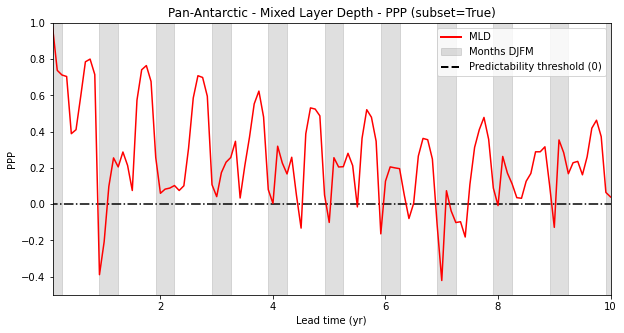

In [106]:
plot_ppp('mld', 'SouthernOcean', subset=True, threshold=0, ymin=-0.5);

opened - /home/bbuchovecky/storage/so_predict_derived/PPP/MLD/mld_ts_so_monthly_ppp.nc


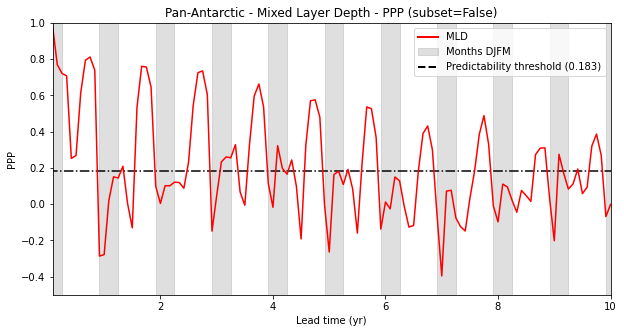

In [107]:
plot_ppp('mld', 'SouthernOcean', threshold=0, subset=False, ymin=-0.5);

opened - /home/bbuchovecky/storage/so_predict_derived/PPP/MLD/mld_ts_so_monthly_subset_ppp.nc


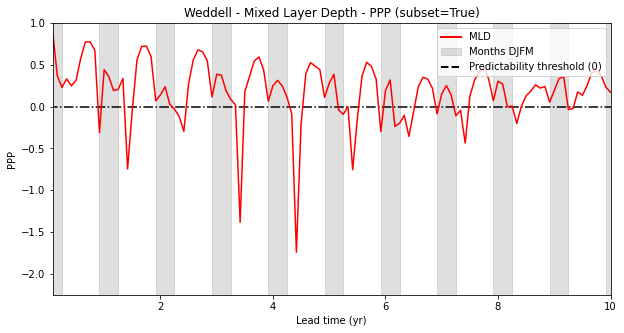

In [118]:
plot_ppp('mld', 'Weddell', subset=True, threshold=0, ymin=-2.25);

opened - /home/bbuchovecky/storage/so_predict_derived/PPP/MLD/mld_ts_so_monthly_ppp.nc


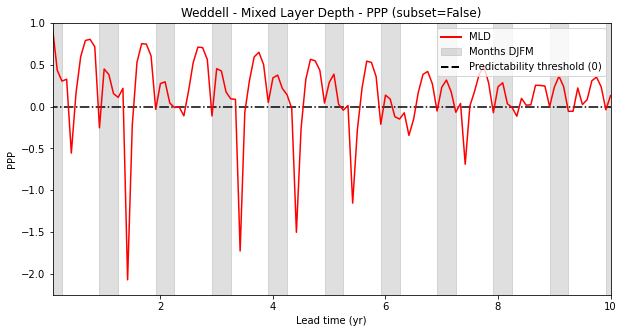

In [119]:
plot_ppp('mld', 'Weddell', threshold=0, subset=False, ymin=-2.25);